In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config
set_config(display='diagram')

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#### Visualizing the data

In [57]:
titanic_train_df = pd.read_csv('train.csv')
titanic_test_df = pd.read_csv('test.csv')

titanic_train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [58]:
print(titanic_train_df.shape)
print(titanic_test_df.shape)

titanic_train_df.info()

(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


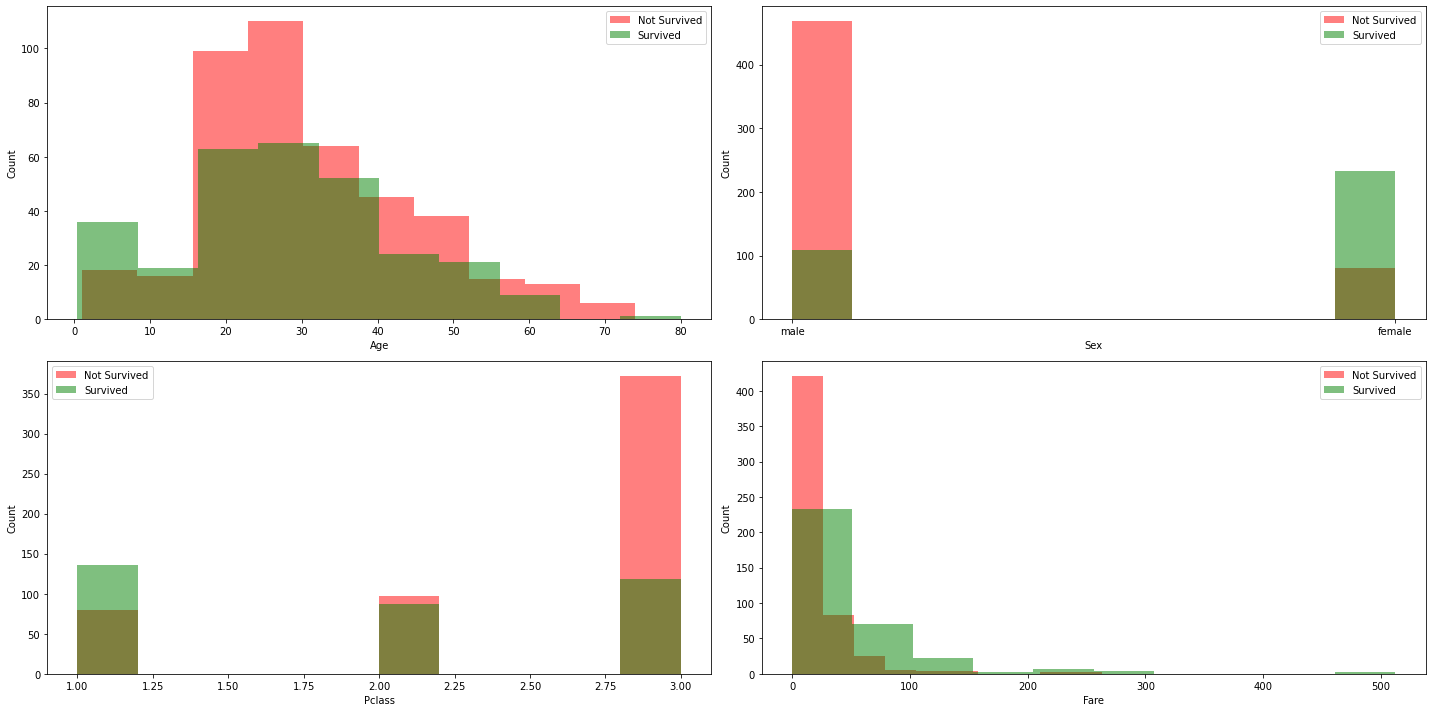

In [59]:
negative_samples = titanic_train_df[titanic_train_df['Survived'] == 0]
positive_samples = titanic_train_df[titanic_train_df['Survived'] == 1]

features = ['Age', 'Sex', 'Pclass', 'Fare']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for f in range(len(features)):
    fig.axes[f].hist(negative_samples[features[f]], alpha=0.5, label='Not Survived', color='red')
    fig.axes[f].hist(positive_samples[features[f]], alpha=0.5, label='Survived', color='green')
    fig.axes[f].set_xlabel(features[f])
    fig.axes[f].set_ylabel('Count')
    fig.axes[f].legend()

fig.tight_layout()
plt.show()

### Interpreting the graphs

We are going to look at two types of factors:

- Gender Proportion
- Economic Status

#### Compare the male to female ratio

The graph above shows that male and female passengers is very dispropotionate. We are going to check out much it is below. 

#### Economic Status

Looking at the graphs Pclass and fare cost, we can see that upper class passengers had a higher survival rate than that of lower class passengers or passengers that paid a lower fare.

In [60]:
male_count = titanic_train_df[titanic_train_df['Sex'] == 'male'].shape[0]
female_count = titanic_train_df[titanic_train_df['Sex'] == 'female'].shape[0]

print(f'Number of Men: {male_count}')
print(f'Number of Female: {female_count}')
print(f'Ratio of Female to Male: {round(female_count / male_count, 2)}')

Number of Men: 577
Number of Female: 314
Ratio of Female to Male: 0.54


Since there is a big difference between the number of male and female passengers, this might lower the accuracy of our predictions. Moving forward we are going to look at economic status for predictions. We are going to train on the features:

- Age
- Pclass
- Fare

In [65]:
scale_features = ['Age', 'Fare']
passthrough_features = ['Pclass']
drop_features = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch']

titanic_train_eco_x = titanic_train_df.drop(columns=['Survived'])
titanic_train_eco_y = titanic_train_df['Survived']

eco_transformer = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), scale_features),
    ('passthrough', passthrough_features),
    ('drop', drop_features),
)

eco_transformer

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('passthrough', 'passthrough', ['Pclass']),
                                ('drop', 'drop',
                                 ['PassengerId', 'Name', 'Sex', 'Ticket',
                                  'Cabin', 'Embarked', 'SibSp', 'Parch'])])

In [75]:
depths = np.linspace(start=1, stop=15, num=5, dtype=int)
eco_tree_scores = {}

for d in depths:
    eco_tree_pipe = make_pipeline(eco_transformer, DecisionTreeClassifier(max_depth=d))
    
    eco_tree_scores[d] = cross_validate(eco_tree_pipe, titanic_train_eco_x, titanic_train_eco_y, cv=5, return_train_score=True)

pd.DataFrame(eco_tree_scores)

,1,4,8,11,15
fit_time,"[0.017362356185913086, 0.018300533294677734, 0...","[0.010169506072998047, 0.010125875473022461, 0...","[0.01012110710144043, 0.01575636863708496, 0.0...","[0.01704549789428711, 0.01178598403930664, 0.0...","[0.013278961181640625, 0.011853218078613281, 0..."
score_time,"[0.010567665100097656, 0.005933046340942383, 0...","[0.0, 0.005821704864501953, 0.0046019554138183...","[0.0109710693359375, 0.0061800479888916016, 0....","[0.00799870491027832, 0.0, 0.00597286224365234...","[0.006834268569946289, 0.00481104850769043, 0...."
test_score,"[0.6145251396648045, 0.6067415730337079, 0.707...","[0.6424581005586593, 0.6853932584269663, 0.713...","[0.6424581005586593, 0.7134831460674157, 0.702...","[0.6312849162011173, 0.6460674157303371, 0.696...","[0.664804469273743, 0.6235955056179775, 0.6235..."
train_score,"[0.6811797752808989, 0.6830294530154277, 0.657...","[0.7514044943820225, 0.7405329593267882, 0.729...","[0.8258426966292135, 0.8036465638148668, 0.805...","[0.8946629213483146, 0.8611500701262272, 0.852...","[0.9353932584269663, 0.9200561009817672, 0.921..."
